<a href="https://colab.research.google.com/github/myreposi/Ds_Samples/blob/master/PySpark_Ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName('tps-2022-ml-with-pyspark').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/train.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [4]:
df.show(5)

df.groupby('Survived').count().show()

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().show()


+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
|PassengerId|Survived|Pclass|            Name| Sex| Age|SibSp|Parch|   Ticket| Fare| Cabin|Embarked|
+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
|          0|       1|     1|Oconnor, Frankie|male|null|    2|    0|   209245|27.14|C12239|       S|
|          1|       0|     3|     Bryan, Drew|male|null|    0|    0|    27323|13.35|  null|       S|
|          2|       0|     3|  Owens, Kenneth|male|0.33|    1|    2|CA 457703|71.29|  null|       S|
|          3|       0|     3|   Kramer, James|male|19.0|    0|    0| A. 10866|13.04|  null|       S|
|          4|       1|     3|   Bond, Michael|male|25.0|    0|    0|   427635| 7.76|  null|       S|
+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
only showing top 5 rows

+--------+-----+
|Survived|count|
+--------+-----+
|       1|42774

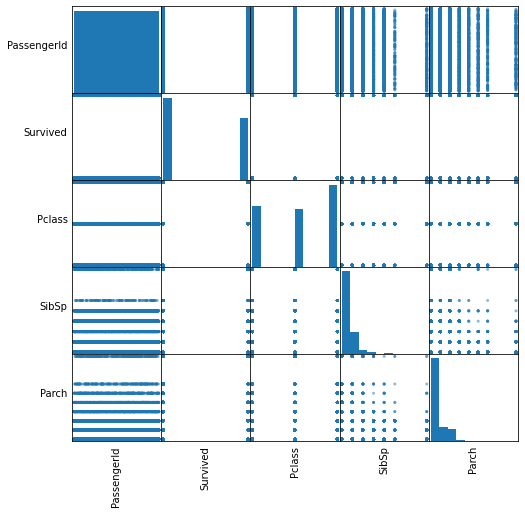

In [5]:
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

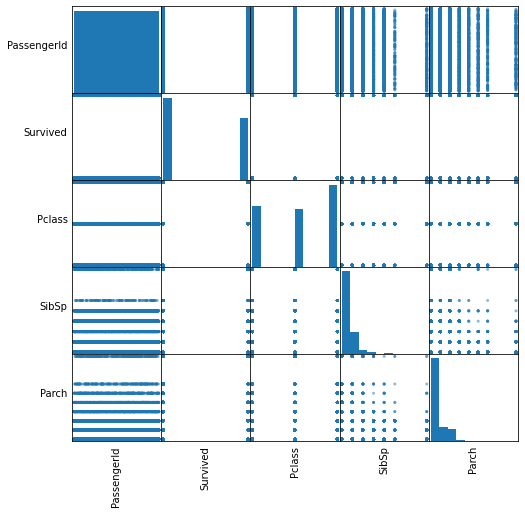

In [6]:
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [7]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|3292|    0|    0|  4623| 134|67866|     250|
+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+



In [8]:
dataset = df.replace('null', None)\
        .dropna(how='any')

In [9]:
dataset.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [10]:
dataset = dataset.drop('PassengerId')
dataset = dataset.drop('Ticket')
dataset = dataset.drop('Fare')
dataset = dataset.drop('Cabin')
dataset = dataset.drop('Embarked')
dataset = dataset.drop('Name')
dataset.show()

+--------+------+------+----+-----+-----+
|Survived|Pclass|   Sex| Age|SibSp|Parch|
+--------+------+------+----+-----+-----+
|       0|     1|  male|27.0|    2|    1|
|       0|     2|  male|66.0|    0|    0|
|       0|     1|  male|60.0|    0|    0|
|       0|     3|  male|36.0|    0|    0|
|       1|     1|female|44.0|    0|    1|
|       1|     1|female|61.0|    0|    4|
|       0|     1|female|53.0|    1|    1|
|       1|     1|female|35.0|    0|    2|
|       1|     1|female|67.0|    1|    0|
|       1|     1|  male|54.0|    0|    0|
|       1|     1|female|69.0|    1|    0|
|       1|     2|female| 7.0|    0|    1|
|       0|     1|  male|43.0|    0|    0|
|       1|     1|  male|63.0|    0|    0|
|       0|     1|  male|45.0|    1|    0|
|       1|     1|female|34.0|    1|    0|
|       1|     1|  male|27.0|    0|    0|
|       1|     1|female|28.0|    0|    1|
|       0|     1|female|36.0|    0|    2|
|       1|     1|female| 5.0|    1|    0|
+--------+------+------+----+-----

In [11]:
sex_in = StringIndexer(inputCol="Sex", outputCol="Sex_encoding")
df1 = sex_in.fit(dataset).transform(dataset)
df1.show()

+--------+------+------+----+-----+-----+------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|Sex_encoding|
+--------+------+------+----+-----+-----+------------+
|       0|     1|  male|27.0|    2|    1|         1.0|
|       0|     2|  male|66.0|    0|    0|         1.0|
|       0|     1|  male|60.0|    0|    0|         1.0|
|       0|     3|  male|36.0|    0|    0|         1.0|
|       1|     1|female|44.0|    0|    1|         0.0|
|       1|     1|female|61.0|    0|    4|         0.0|
|       0|     1|female|53.0|    1|    1|         0.0|
|       1|     1|female|35.0|    0|    2|         0.0|
|       1|     1|female|67.0|    1|    0|         0.0|
|       1|     1|  male|54.0|    0|    0|         1.0|
|       1|     1|female|69.0|    1|    0|         0.0|
|       1|     2|female| 7.0|    0|    1|         0.0|
|       0|     1|  male|43.0|    0|    0|         1.0|
|       1|     1|  male|63.0|    0|    0|         1.0|
|       0|     1|  male|45.0|    1|    0|         1.0|
|       1|

In [12]:
required_features = ['Survived',
                    'Pclass',
                    'SibSp',
                    'Parch',
                     'Age',
                     'Sex_encoding'
                   ]

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

transformed_data = assembler.transform(df1)

In [13]:
transformed_data.show()

+--------+------+------+----+-----+-----+------------+--------------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|Sex_encoding|            features|
+--------+------+------+----+-----+-----+------------+--------------------+
|       0|     1|  male|27.0|    2|    1|         1.0|[0.0,1.0,2.0,1.0,...|
|       0|     2|  male|66.0|    0|    0|         1.0|[0.0,2.0,0.0,0.0,...|
|       0|     1|  male|60.0|    0|    0|         1.0|[0.0,1.0,0.0,0.0,...|
|       0|     3|  male|36.0|    0|    0|         1.0|[0.0,3.0,0.0,0.0,...|
|       1|     1|female|44.0|    0|    1|         0.0|[1.0,1.0,0.0,1.0,...|
|       1|     1|female|61.0|    0|    4|         0.0|[1.0,1.0,0.0,4.0,...|
|       0|     1|female|53.0|    1|    1|         0.0|[0.0,1.0,1.0,1.0,...|
|       1|     1|female|35.0|    0|    2|         0.0|[1.0,1.0,0.0,2.0,...|
|       1|     1|female|67.0|    1|    0|         0.0|[1.0,1.0,1.0,0.0,...|
|       1|     1|  male|54.0|    0|    0|         1.0|[1.0,1.0,0.0,0.0,...|
|       1|  

In [14]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

In [15]:
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 24708
Test Dataset Count: 6173


In [16]:
rf = RandomForestClassifier(labelCol='Survived', 
                            featuresCol='features',
                            maxDepth=5)
model = rf.fit(training_data)
rf_predictions = model.transform(test_data)

In [17]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 1.0


In [18]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Survived', maxDepth = 3)
dtModel = dt.fit(training_data)
dt_predictions = dtModel.transform(test_data)
dt_predictions.select('Sex_encoding', 'Pclass','SibSp', 'Parch', 'Age', 'Survived').show(10)

+------------+------+-----+-----+---+--------+
|Sex_encoding|Pclass|SibSp|Parch|Age|Survived|
+------------+------+-----+-----+---+--------+
|         0.0|     1|    1|    2|1.0|       0|
|         0.0|     1|    4|    2|1.0|       0|
|         0.0|     1|    1|    2|3.0|       0|
|         0.0|     1|    1|    2|3.0|       0|
|         0.0|     1|    1|    0|4.0|       0|
|         0.0|     1|    1|    2|4.0|       0|
|         0.0|     1|    1|    2|4.0|       0|
|         0.0|     1|    0|    0|5.0|       0|
|         0.0|     1|    0|    0|5.0|       0|
|         0.0|     1|    0|    2|5.0|       0|
+------------+------+-----+-----+---+--------+
only showing top 10 rows



In [19]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 1.0


In [20]:
gb = GBTClassifier(labelCol = 'Survived', featuresCol = 'features')
gbModel = gb.fit(training_data)
gb_predictions = gbModel.transform(test_data)

In [21]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Gradient-boosted Trees Accuracy:', multi_evaluator.evaluate(gb_predictions))

Gradient-boosted Trees Accuracy: 1.0


In [22]:
df_pd = gb_predictions.toPandas()

In [23]:
df_pd.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Sex_encoding,features,rawPrediction,probability,prediction
0,0,1,female,1.0,1,2,0.0,"[0.0, 1.0, 1.0, 2.0, 1.0, 0.0]","[1.54350200272501, -1.54350200272501]","[0.9563534785727089, 0.043646521427291085]",0.0
1,0,1,female,1.0,4,2,0.0,"[0.0, 1.0, 4.0, 2.0, 1.0, 0.0]","[1.5435020027250088, -1.5435020027250088]","[0.9563534785727089, 0.043646521427291085]",0.0
2,0,1,female,3.0,1,2,0.0,"[0.0, 1.0, 1.0, 2.0, 3.0, 0.0]","[1.54350200272501, -1.54350200272501]","[0.9563534785727089, 0.043646521427291085]",0.0
3,0,1,female,3.0,1,2,0.0,"[0.0, 1.0, 1.0, 2.0, 3.0, 0.0]","[1.54350200272501, -1.54350200272501]","[0.9563534785727089, 0.043646521427291085]",0.0
4,0,1,female,4.0,1,0,0.0,"[0.0, 1.0, 1.0, 0.0, 4.0, 0.0]","[1.54350200272501, -1.54350200272501]","[0.9563534785727089, 0.043646521427291085]",0.0


In [24]:
df_pd.to_csv("gbModel.csv",index = False)
gb_df = pd.read_csv("./gbModel.csv")
gb_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Sex_encoding,features,rawPrediction,probability,prediction
0,0,1,female,1.0,1,2,0.0,"[0.0,1.0,1.0,2.0,1.0,0.0]","[1.54350200272501,-1.54350200272501]","[0.9563534785727089,0.043646521427291085]",0.0
1,0,1,female,1.0,4,2,0.0,"[0.0,1.0,4.0,2.0,1.0,0.0]","[1.5435020027250088,-1.5435020027250088]","[0.9563534785727089,0.043646521427291085]",0.0
2,0,1,female,3.0,1,2,0.0,"[0.0,1.0,1.0,2.0,3.0,0.0]","[1.54350200272501,-1.54350200272501]","[0.9563534785727089,0.043646521427291085]",0.0
3,0,1,female,3.0,1,2,0.0,"[0.0,1.0,1.0,2.0,3.0,0.0]","[1.54350200272501,-1.54350200272501]","[0.9563534785727089,0.043646521427291085]",0.0
4,0,1,female,4.0,1,0,0.0,"[0.0,1.0,1.0,0.0,4.0,0.0]","[1.54350200272501,-1.54350200272501]","[0.9563534785727089,0.043646521427291085]",0.0


In [25]:
submission  = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")
submission = submission.drop("Survived",axis=1)
submission.head()

,PassengerId
0,100000
1,100001
2,100002
3,100003
4,100004


In [26]:
results = pd.concat([submission,gb_df.Survived],axis = 1)
results.to_csv("submission.csv", index = False)
